In [ ]:
import pandas as pd

# =========================================================
# 1. LOAD CSV
# =========================================================
df = pd.read_csv("api_data_aadhar_demographic_2000000_2071700.csv")

# Clean column names
df.columns = df.columns.str.strip()

# =========================================================
# 2. STANDARDIZE TEXT COLUMNS (STATE & DISTRICT)
# =========================================================
def clean_text(x):
    if pd.isna(x):
        return x
    return str(x).strip().lower().title()

df["state"] = df["state"].apply(clean_text)
df["district"] = df["district"].apply(clean_text)

# =========================================================
# 3. ROBUST DATE PARSING (MAXIMUM CORRECTNESS)
#   '/'  -> MM/DD/YYYY
#   '-'  -> DD-MM-YYYY
# =========================================================
def parse_mixed_date(x):
    if pd.isna(x):
        return pd.NaT

    x = str(x).strip()

    if "/" in x:
        return pd.to_datetime(x, format="%m/%d/%Y", errors="coerce")

    if "-" in x:
        return pd.to_datetime(x, format="%d-%m-%Y", errors="coerce")

    return pd.NaT

df["date"] = df["date"].apply(parse_mixed_date)

# =========================================================
# 4. SANITY CHECK FOR BAD DATES
# =========================================================
bad_dates = df["date"].isna().sum()
print(f"Invalid / unparsed dates: {bad_dates}")

if bad_dates > 0:
    print("Sample problematic rows:")
    print(df[df["date"].isna()].head())

# =========================================================
# 5. SORT: STATE-WISE → DATE-WISE
# =========================================================
df_sorted = (
    df.sort_values(by=["state", "date"])
      .reset_index(drop=True)
)

# =========================================================
# 6. SAVE CLEANED & SORTED DATA
# =========================================================
df_sorted.to_csv("state_date_sorted.csv", index=False)

# =========================================================
# 7. CREATE EXCEL WITH ONE SHEET PER STATE
# =========================================================
output_excel = "state_wise_data_20L.xlsx"

with pd.ExcelWriter(output_excel, engine="openpyxl") as writer:
    for state, state_df in df_sorted.groupby("state"):
        sheet_name = state[:31]  # Excel limit
        state_df.to_excel(writer, sheet_name=sheet_name, index=False)

print("✔ CSV cleaned, sorted, and Excel file with state-wise sheets created.")


Invalid / unparsed dates: 0
✔ CSV cleaned, sorted, and Excel file with state-wise sheets created.


In [ ]:
import pandas as pd
import numpy as np
import os

# ==================================================
# CONFIG
# ==================================================
folder_path = r"C:\Users\dell\Desktop\hackathon\complete dataset\excel sheets - old"
excel_files = [f for f in os.listdir(folder_path) if f.endswith(".xlsx")]

# Storage for file-wise aggregates
state_level_chunks = []
district_level_chunks = []
pincode_level_chunks = []

# ==================================================
# FILE-WISE PROCESSING
# ==================================================
for file in excel_files:
    print(f"Processing file: {file}")
    xls = pd.ExcelFile(os.path.join(folder_path, file))

    for sheet in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet)
        df.columns = df.columns.str.strip()

        # ---------- REQUIRED COLUMN CHECK ----------
        required_cols = {
            "state",
            "district",
            "pincode",
            "demo_age_17_",
            "demo_age_5_17"
        }

        if not required_cols.issubset(df.columns):
            print(f"Skipping {file} | {sheet} (missing columns)")
            continue

        # ---------- STATE LEVEL ----------
        state_agg = (
            df.groupby("state")
              .agg(
                  sum_17_plus=("demo_age_17_", "sum"),
                  mean_17_plus=("demo_age_17_", "mean"),
                  std_17_plus=("demo_age_17_", "std"),
                  sum_5_17=("demo_age_5_17", "sum"),
                  mean_5_17=("demo_age_5_17", "mean"),
                  std_5_17=("demo_age_5_17", "std")
              )
              .reset_index()
        )
        state_level_chunks.append(state_agg)

        # ---------- DISTRICT LEVEL ----------
        district_agg = (
            df.groupby(["state", "district"])
              .agg(sum_17_plus=("demo_age_17_", "sum"))
              .reset_index()
        )
        district_level_chunks.append(district_agg)

        # ---------- PINCODE LEVEL ----------
        pincode_agg = (
            df.groupby(["state", "district", "pincode"])
              .agg(sum_17_plus=("demo_age_17_", "sum"))
              .reset_index()
        )
        pincode_level_chunks.append(pincode_agg)

# ==================================================
# COMBINE STATE-LEVEL RESULTS
# ==================================================
state_combined = (
    pd.concat(state_level_chunks)
    .groupby("state")
    .agg(
        sum_17_plus=("sum_17_plus", "sum"),
        sum_5_17=("sum_5_17", "sum"),
        mean_17_plus=("mean_17_plus", "mean"),
        std_17_plus=("std_17_plus", "mean"),
        mean_5_17=("mean_5_17", "mean"),
        std_5_17=("std_5_17", "mean")
    )
    .reset_index()
)

state_combined["total_relocation"] = (
    state_combined["sum_17_plus"] + state_combined["sum_5_17"]
)

# ==================================================
# NORMALISED INTENSITY
# ==================================================
median_total = state_combined["total_relocation"].median()
state_combined["Relocation_Intensity_Index"] = (
    state_combined["total_relocation"] / median_total
)

# ==================================================
# HOUSEHOLD STRUCTURE
# ==================================================
state_combined["Child_Dependency_Ratio"] = (
    state_combined["sum_5_17"] / state_combined["total_relocation"]
)

state_combined["Adult_Dominance_Index"] = (
    (state_combined["sum_17_plus"] - state_combined["sum_5_17"]) /
    state_combined["sum_17_plus"]
)

# ==================================================
# COMBINE DISTRICT-LEVEL RESULTS
# ==================================================
district_combined = (
    pd.concat(district_level_chunks)
    .groupby(["state", "district"])["sum_17_plus"]
    .sum()
    .reset_index()
)

# ---------- PEAK DISTRICT ----------
peak_district = district_combined.loc[
    district_combined.groupby("state")["sum_17_plus"].idxmax()
].reset_index(drop=True)

state_totals = (
    district_combined.groupby("state")["sum_17_plus"]
    .sum()
    .reset_index(name="state_total")
)

peak_district = peak_district.merge(state_totals, on="state")
peak_district["Peak_District_Share"] = (
    peak_district["sum_17_plus"] / peak_district["state_total"]
)

# ==================================================
# SPATIAL CONCENTRATION INDEX (SCI)
# ==================================================
sci = (
    district_combined
    .assign(share=lambda x:
        x["sum_17_plus"] /
        x.groupby("state")["sum_17_plus"].transform("sum")
    )
    .assign(hhi=lambda x: x["share"] ** 2)
    .groupby("state")["hhi"]
    .sum()
    .reset_index(name="Spatial_Concentration_Index")
)

# ==================================================
# COMBINE PINCODE-LEVEL RESULTS
# ==================================================
pincode_combined = (
    pd.concat(pincode_level_chunks)
    .groupby(["state", "district", "pincode"])["sum_17_plus"]
    .sum()
    .reset_index()
)

# ---------- PEAK PINCODE WITHIN PEAK DISTRICT ----------
pincode_in_peak_district = pincode_combined.merge(
    peak_district[["state", "district"]],
    on=["state", "district"],
    how="inner"
)

peak_pincode = pincode_in_peak_district.loc[
    pincode_in_peak_district.groupby(["state", "district"])["sum_17_plus"].idxmax()
].reset_index(drop=True)

district_totals_for_pincode = (
    pincode_in_peak_district
    .groupby(["state", "district"])["sum_17_plus"]
    .sum()
    .reset_index(name="district_total")
)

peak_pincode = peak_pincode.merge(
    district_totals_for_pincode,
    on=["state", "district"]
)

peak_pincode["Peak_Pincode_Share_in_District"] = (
    peak_pincode["sum_17_plus"] / peak_pincode["district_total"]
)

# ==================================================
# FINAL MASTER TABLE 1
# ==================================================
master_table_1 = (
    state_combined
    .merge(
        peak_district[["state", "district", "Peak_District_Share"]],
        on="state"
    )
    .merge(sci, on="state")
    .merge(
        peak_pincode[[
            "state",
            "district",
            "pincode",
            "Peak_Pincode_Share_in_District"
        ]],
        on=["state", "district"],
        how="left"
    )
)

master_table_1.rename(
    columns={
        "district": "Peak_District",
        "pincode": "Peak_Pincode"
    },
    inplace=True
)

# ==================================================
# KEY SPATIAL INSIGHT
# ==================================================
def spatial_conclusion(row):
    if row["Child_Dependency_Ratio"] < 0.5 and row["Spatial_Concentration_Index"] > 0.35:
        return "Individual-dominated, hub-centric relocation"
    elif row["Child_Dependency_Ratio"] > 0.6 and row["Spatial_Concentration_Index"] < 0.25:
        return "Family-centric, dispersed relocation"
    elif row["Peak_Pincode_Share_in_District"] > 0.5:
        return "Extreme micro-level spatial concentration"
    elif row["Spatial_Concentration_Index"] > 0.4:
        return "Structural relocation hub"
    else:
        return "Mixed spatial relocation pattern"

master_table_1["Key_Spatial_Insight"] = (
    master_table_1.apply(spatial_conclusion, axis=1)
)

# ==================================================
# SAVE OUTPUT
# ==================================================
master_table_1.to_excel(
    "master_table_1_spatial_structural_new.xlsx",
    index=False
)

print("✔ MASTER TABLE 1 CREATED SUCCESSFULLY")


Processing file: master_table_1_spatial_structural_new.xlsx
Skipping master_table_1_spatial_structural_new.xlsx | Sheet1 (missing columns)
Processing file: master_table_2_temporal_dynamics.xlsx
Skipping master_table_2_temporal_dynamics.xlsx | Sheet1 (missing columns)
Processing file: state_wise_data_0 to 5L.xlsx
Processing file: state_wise_data_10L to 15L.xlsx
Processing file: state_wise_data_15L to 20L.xlsx
Processing file: state_wise_data_20L.xlsx
Processing file: state_wise_data_5L to 10L.xlsx
✔ MASTER TABLE 1 CREATED SUCCESSFULLY


In [ ]:
import pandas as pd
import numpy as np
import os

# ==================================================
# CONFIG
# ==================================================
folder_path = r"C:\Users\dell\Desktop\hackathon\complete dataset\excel sheets - old"
excel_files = [f for f in os.listdir(folder_path) if f.endswith(".xlsx")]

monthly_chunks = []

# ==================================================
# FILE-WISE PROCESSING
# ==================================================
for file in excel_files:
    print(f"Processing file: {file}")
    xls = pd.ExcelFile(os.path.join(folder_path, file))

    for sheet in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet)
        df.columns = df.columns.str.strip()

        required_cols = {
            "state", "district", "pincode", "date",
            "demo_age_17_", "demo_age_5_17"
        }

        if not required_cols.issubset(df.columns):
            print(f"Skipping {file} | {sheet}")
            continue

        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df["month"] = df["date"].dt.to_period("M")

        month_agg = (
            df.groupby(["state", "month"])
              .agg(
                  sum_17_plus=("demo_age_17_", "sum"),
                  mean_17_plus=("demo_age_17_", "mean"),
                  std_17_plus=("demo_age_17_", "std"),
                  sum_5_17=("demo_age_5_17", "sum"),
                  mean_5_17=("demo_age_5_17", "mean"),
                  std_5_17=("demo_age_5_17", "std")
              )
              .reset_index()
        )

        monthly_chunks.append(month_agg)

# ==================================================
# COMBINE MONTHLY RESULTS
# ==================================================
state_month = (
    pd.concat(monthly_chunks)
    .groupby(["state", "month"])
    .agg(
        sum_17_plus=("sum_17_plus", "sum"),
        mean_17_plus=("mean_17_plus", "mean"),
        std_17_plus=("std_17_plus", "mean"),
        sum_5_17=("sum_5_17", "sum"),
        mean_5_17=("mean_5_17", "mean"),
        std_5_17=("std_5_17", "mean")
    )
    .reset_index()
    .sort_values(["state", "month"])
)

# ==================================================
# TEMPORAL METRICS
# ==================================================
state_month["Family_Relocation_Ratio"] = (
    state_month["sum_5_17"] /
    state_month["sum_17_plus"].replace(0, np.nan)
)

state_month["Monthly_Growth_Rate"] = (
    state_month.groupby("state")["sum_17_plus"].pct_change()
)

state_month["Momentum_Indicator"] = (
    state_month.groupby("state")["sum_17_plus"]
    .apply(lambda x: np.log(x.replace(0, np.nan)).diff())
)

state_month["Rolling_Volatility"] = (
    state_month.groupby("state")["sum_17_plus"]
    .transform(lambda x: x.rolling(6, min_periods=3).std())
)

# ==================================================
# KEY TEMPORAL INSIGHT
# ==================================================
vol_threshold = state_month["Rolling_Volatility"].quantile(0.75)

def temporal_conclusion(row):
    if row["Momentum_Indicator"] > 0 and row["Rolling_Volatility"] < vol_threshold:
        return "Steady growth in permanent relocation"
    elif row["Momentum_Indicator"] < 0:
        return "Relocation slowdown or saturation"
    elif row["Rolling_Volatility"] > vol_threshold:
        return "Volatile or shock-driven relocation"
    else:
        return "Stable relocation trend"

state_month["Key_Temporal_Insight"] = (
    state_month.apply(temporal_conclusion, axis=1)
)

state_month.to_excel(
    "master_table_2_temporal_dynamics.xlsx",
    index=False
)

print("✔ Master Table 2 created")


Processing file: master_table_1_spatial_structural_new.xlsx
Skipping master_table_1_spatial_structural_new.xlsx | Sheet1
Processing file: master_table_2_temporal_dynamics.xlsx
Skipping master_table_2_temporal_dynamics.xlsx | Sheet1
Processing file: state_wise_data_0 to 5L.xlsx
Processing file: state_wise_data_10L to 15L.xlsx
Processing file: state_wise_data_15L to 20L.xlsx
Processing file: state_wise_data_20L.xlsx
Processing file: state_wise_data_5L to 10L.xlsx


C:\Users\dell\AppData\Local\Temp\ipykernel_11820\2155500527.py:83: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: np.log(x.replace(0, np.nan)).diff())


✔ Master Table 2 created


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ==================================================
# LOAD MASTER TABLE 1
# ==================================================
mt1 = pd.read_excel("master_table_1_spatial_structural_new.xlsx")

# ==================================================
# PREP DATA
# ==================================================
mt1["total_relocation"] = mt1["sum_17_plus"] + mt1["sum_5_17"]

# Peak district absolute level (adult-based)
mt1["peak_district_level"] = (
    mt1["Peak_District_Share"] * mt1["total_relocation"]
)

# Sort states by total relocation for readability
mt1 = mt1.sort_values("total_relocation", ascending=False)

states = mt1["state"]
x = np.arange(len(states))

# ==================================================
# CREATE PLOT
# ==================================================
plt.figure(figsize=(14,7))

# --- STACKED BARS ---
plt.bar(
    x,
    mt1["sum_17_plus"],
    label="Age 17+",
    color="#4C72B0"
)

plt.bar(
    x,
    mt1["sum_5_17"],
    bottom=mt1["sum_17_plus"],
    label="Age 5–17",
    color="#55A868"
)

# --- PEAK DISTRICT LINE ---
plt.plot(
    x,
    mt1["peak_district_level"],
    color="#C44E52",
    marker="o",
    linewidth=2,
    label="Peak District"
)

# ==================================================
# AXES & LABELS
# ==================================================
plt.xticks(x, states, rotation=90)
plt.ylabel("Frequency of Permanent Address Change")
plt.xlabel("State")
plt.title(
    "State-wise Relocation Volume, Age Composition, and Peak District Dominance"
)

plt.legend()
plt.tight_layout()

# ==================================================
# SAVE
# ==================================================
os.makedirs("graphs", exist_ok=True)
plt.savefig("graphs/I_state_district_composition_peak_overlay.png")
plt.close()

print("✔ Graph generated: state-wise district & age composition")


✔ Graph generated: state-wise district & age composition


Months plotted (>=90% state coverage):
['2025-03', '2025-09', '2025-10', '2025-11', '2025-12']


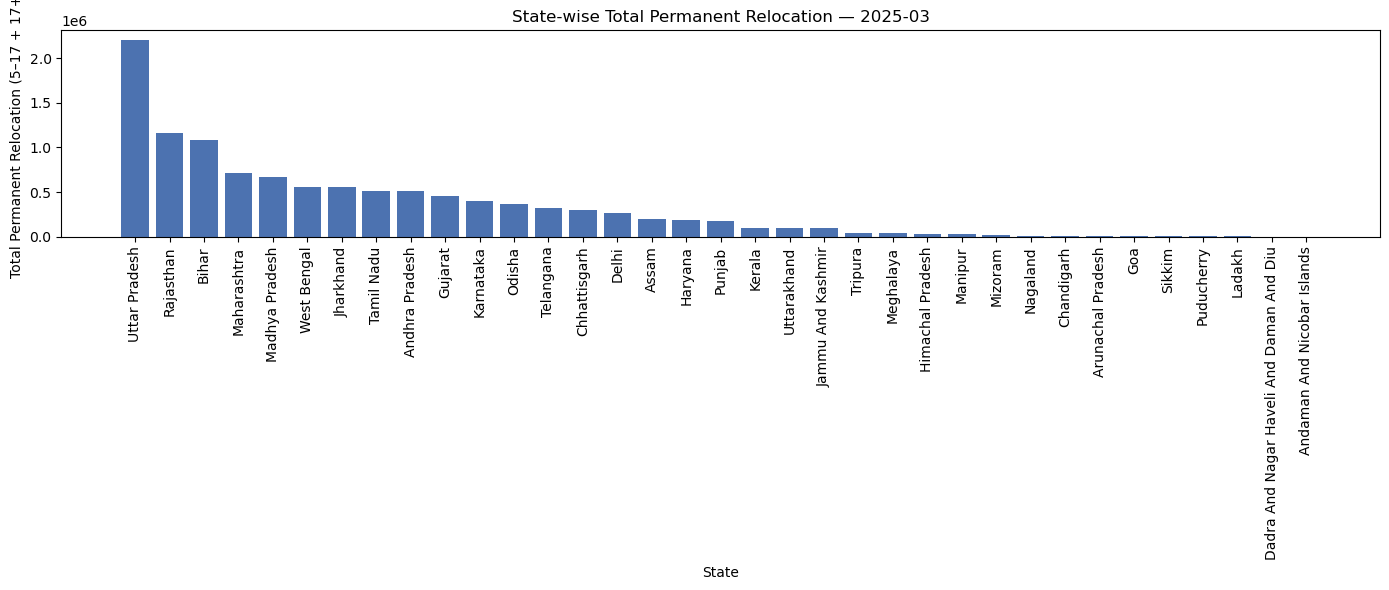

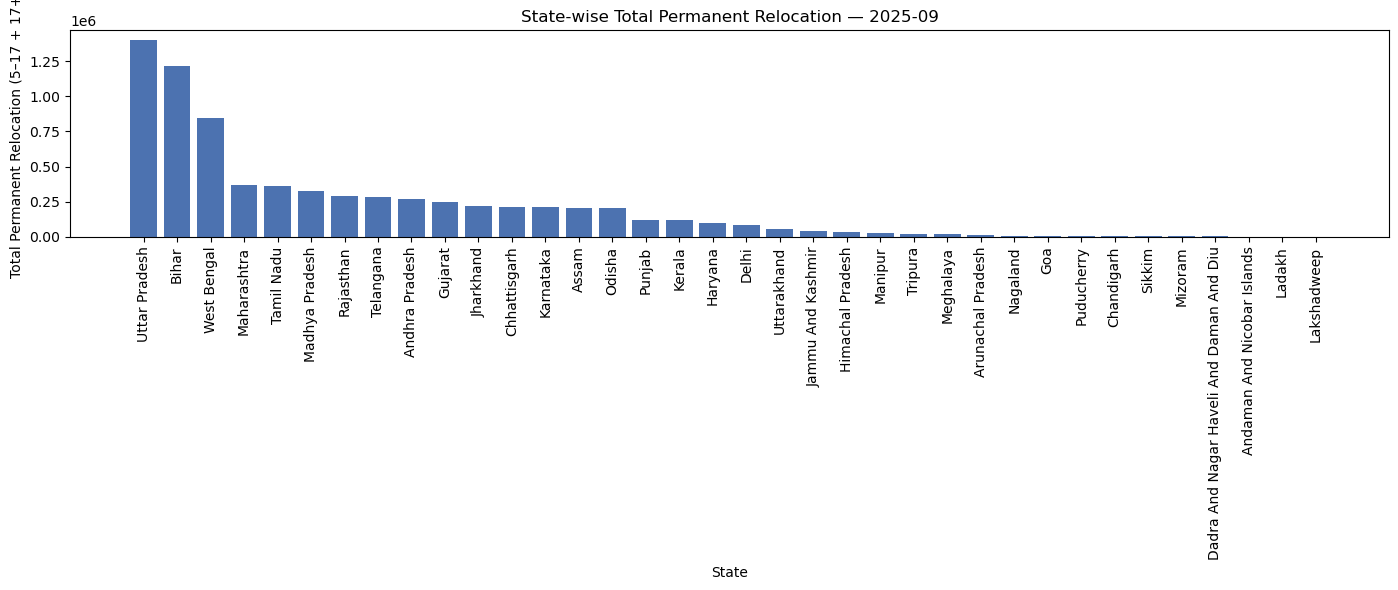

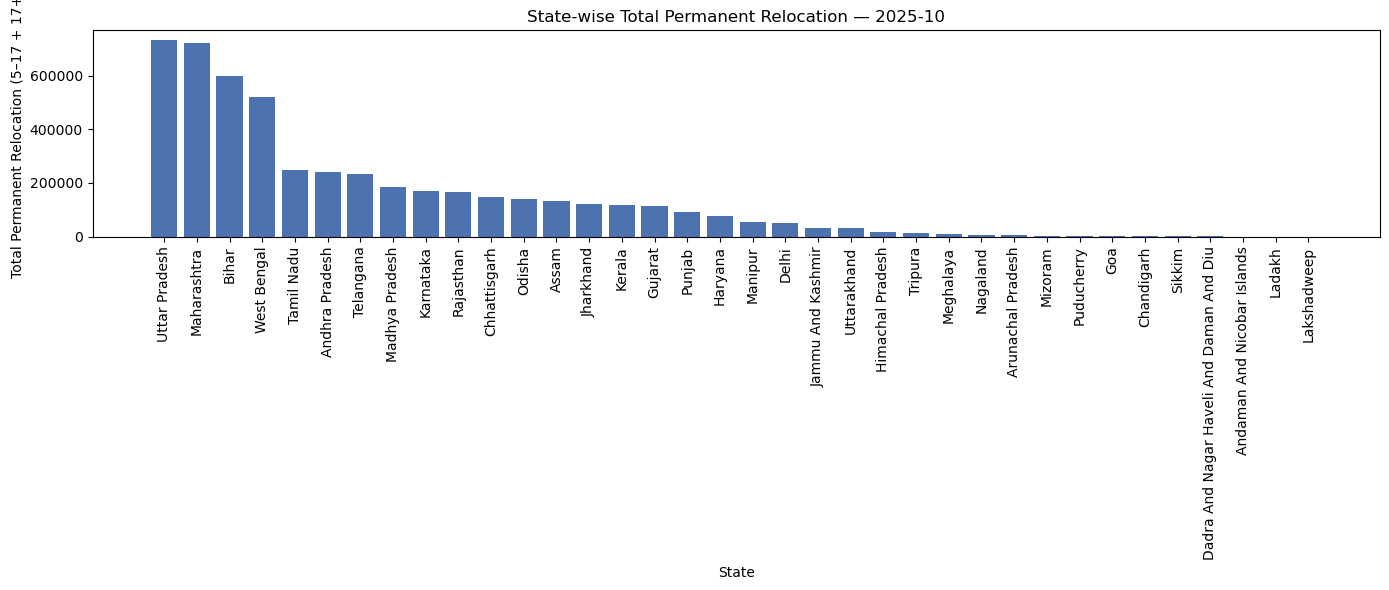

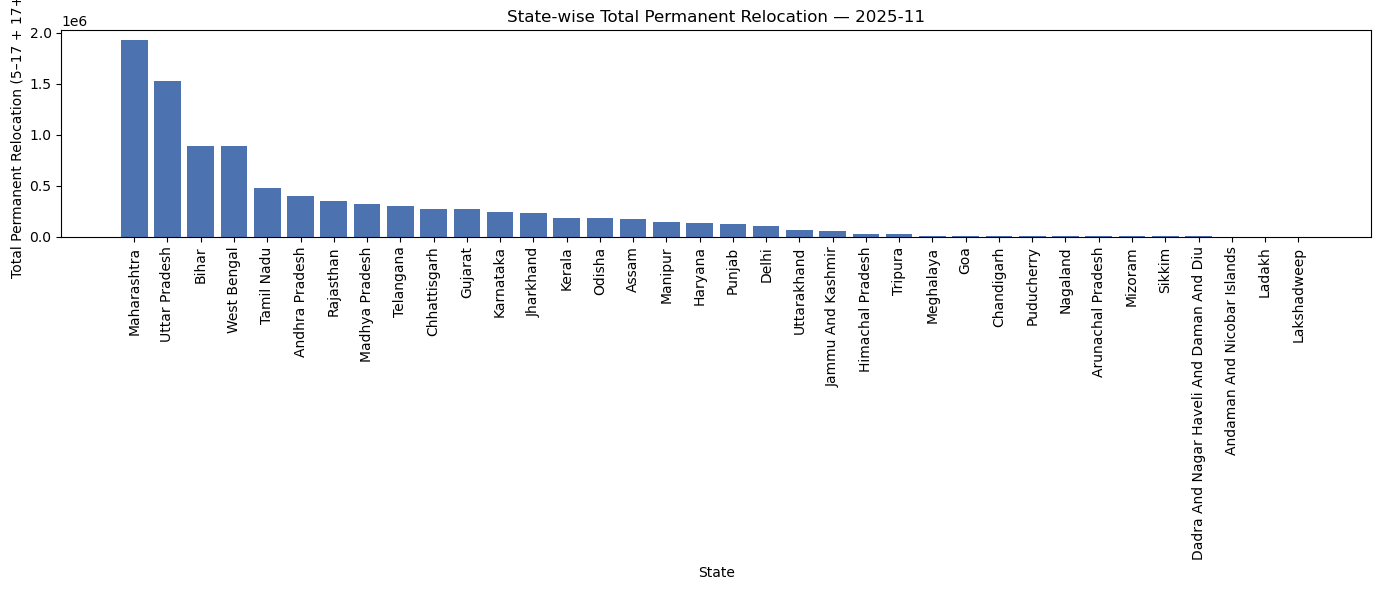

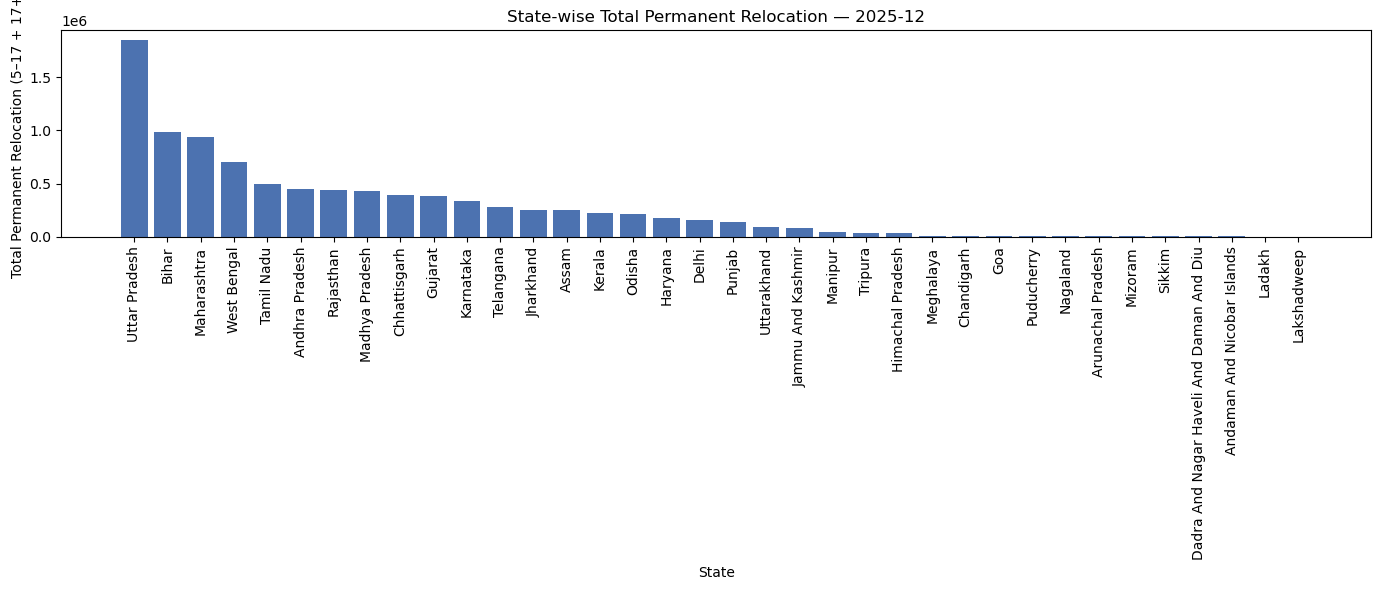

✔ Graphs displayed in VS Code and saved to disk


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ==================================================
# LOAD MASTER TABLE 2
# ==================================================
mt2 = pd.read_excel("master_table_2_temporal_dynamics.xlsx")

mt2["month"] = mt2["month"].astype(str)
mt2["total_relocation"] = mt2["sum_17_plus"] + mt2["sum_5_17"]

# ==================================================
# MONTH COVERAGE CHECK (90% RULE)
# ==================================================
total_states = mt2["state"].nunique()
threshold = int(0.9 * total_states)

month_state_counts = (
    mt2.groupby("month")["state"]
    .nunique()
    .reset_index(name="state_count")
)

usable_months = month_state_counts[
    month_state_counts["state_count"] >= threshold
]["month"].tolist()

print("Months plotted (>=90% state coverage):")
print(usable_months)

# ==================================================
# OUTPUT FOLDER
# ==================================================
os.makedirs("graphs_monthwise", exist_ok=True)

# ==================================================
# PLOT + SHOW + SAVE
# ==================================================
for month in usable_months:
    subset = (
        mt2[mt2["month"] == month]
        .sort_values("total_relocation", ascending=False)
    )

    plt.figure(figsize=(14,6))
    plt.bar(subset["state"], subset["total_relocation"], color="#4C72B0")

    plt.xticks(rotation=90)
    plt.ylabel("Total Permanent Relocation (5–17 + 17+)")
    plt.xlabel("State")
    plt.title(f"State-wise Total Permanent Relocation — {month}")

    plt.tight_layout()

    # SAVE
    plt.savefig(f"graphs_monthwise/state_total_relocation_{month}.png")

    # SHOW IN VS CODE
    plt.show()

    # CLOSE TO FREE MEMORY
    plt.close()

print("✔ Graphs displayed in VS Code and saved to disk")


In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import os

# ==================================================
# CONFIG
# ==================================================
STATE_ZIP_URL = (
    "https://github.com/AnujTiwari/"
    "India-State-and-Country-Shapefile-Updated-Jan-2020/"
    "archive/refs/heads/master.zip"
)

DISTRICT_ZIP_URL = (
    "https://data.humdata.org/dataset/"
    "e66b3c2a-0d55-4d3c-9d8f-2c6c1a3a3e18/"
    "resource/2f2c7a7c-9b9f-4c41-b1f7-8fbb8c5b7d90/"
    "download/ind_adm2.zip"
)

BASE_DIR = "india_geo_data"
STATE_DIR = os.path.join(BASE_DIR, "states")
DISTRICT_DIR = os.path.join(BASE_DIR, "districts")

os.makedirs(STATE_DIR, exist_ok=True)
os.makedirs(DISTRICT_DIR, exist_ok=True)

# ==================================================
# STEP 1: DOWNLOAD & EXTRACT STATE SHAPEFILE
# ==================================================
state_zip = os.path.join(STATE_DIR, "states.zip")

if not os.path.exists(state_zip):
    print("Downloading India State boundaries...")
    r = requests.get(STATE_ZIP_URL)
    with open(state_zip, "wb") as f:
        f.write(r.content)

with zipfile.ZipFile(state_zip, "r") as zip_ref:
    zip_ref.extractall(STATE_DIR)

STATE_SHP = os.path.join(
    STATE_DIR,
    "India-State-and-Country-Shapefile-Updated-Jan-2020-master",
    "India-States",
    "India_States.shp"
)

# ==================================================
# STEP 2: DOWNLOAD & EXTRACT DISTRICT SHAPEFILE
# ==================================================
district_zip = os.path.join(DISTRICT_DIR, "districts.zip")

if not os.path.exists(district_zip):
    print("Downloading India District boundaries...")
    r = requests.get(DISTRICT_ZIP_URL)
    with open(district_zip, "wb") as f:
        f.write(r.content)

with zipfile.ZipFile(district_zip, "r") as zip_ref:
    zip_ref.extractall(DISTRICT_DIR)

DISTRICT_SHP = os.path.join(
    DISTRICT_DIR,
    "ind_adm2.shp"
)

# ==================================================
# STEP 3: LOAD MASTER TABLE 1
# ==================================================
mt1 = pd.read_excel("master_table_1_spatial_structural.xlsx")

mt1["total_relocation"] = mt1["sum_17_plus"] + mt1["sum_5_17"]

mt1["state"] = mt1["state"].str.lower().str.strip()
mt1["Peak_District"] = mt1["Peak_District"].str.lower().str.strip()

# ==================================================
# STEP 4: LOAD STATE & DISTRICT MAPS
# ==================================================
india_states = gpd.read_file(STATE_SHP)
india_states["state"] = india_states["st_nm"].str.lower().str.strip()

india_districts = gpd.read_file(DISTRICT_SHP)
india_districts["state"] = india_districts["NAME_1"].str.lower().str.strip()
india_districts["district"] = india_districts["NAME_2"].str.lower().str.strip()

# ==================================================
# STEP 5: MERGE STATE DATA
# ==================================================
state_map = india_states.merge(
    mt1,
    on="state",
    how="left"
)

# ==================================================
# STEP 6: IDENTIFY PEAK DISTRICTS (PRECISE)
# ==================================================
peak_districts = india_districts.merge(
    mt1[["state", "Peak_District"]],
    left_on=["state", "district"],
    right_on=["state", "Peak_District"],
    how="inner"
)

# Use representative interior points (GOVT-GRADE)
peak_districts["geometry"] = peak_districts.geometry.representative_point()

peak_points = gpd.GeoDataFrame(
    peak_districts,
    geometry="geometry",
    crs=india_districts.crs
)

# ==================================================
# STEP 7: PLOT MAP
# ==================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# State choropleth
state_map.plot(
    column="total_relocation",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": "Total Permanent Relocation Frequency",
        "shrink": 0.6
    }
)

# Peak district markers
peak_points.plot(
    ax=ax,
    color="blue",
    markersize=30,
    alpha=0.85,
    label="Peak District"
)

ax.set_title(
    "State-wise Permanent Internal Migration in India\n"
    "with Peak District Locations",
    fontsize=14
)

ax.axis("off")
ax.legend()

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'geopandas'

In [1]:
import pandas as pd
import numpy as np

# ==============================
# INPUT FILES
# ==============================
files = {
    "master_table_1": "master_table_1_spatial_structural_new.xlsx",
    "master_table_2": "master_table_2_temporal_dynamics.xlsx"
}

for name, path in files.items():
    df = pd.read_excel(path)

    # Round numeric columns to 2 decimals
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].round(2)

    # Save rounded Excel
    df.to_excel(f"{name}_rounded.xlsx", index=False)

    # Export LaTeX table for Overleaf
    df.to_latex(
        f"{name}.tex",
        index=False,
        escape=False
    )

    print(f"✔ Processed and exported: {name}")


C:\Users\dell\AppData\Local\Temp\ipykernel_14276\1145944046.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


✔ Processed and exported: master_table_1


C:\Users\dell\AppData\Local\Temp\ipykernel_14276\1145944046.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


✔ Processed and exported: master_table_2
